In [1]:
%matplotlib inline
import sys
sys.path.insert(0, './pdn')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

from pdn_parser import NetlistParser
from core import (
    UnifiedPowerGridModel,
    UnifiedIRDropSolver,
    UnifiedHierarchicalResult,
    UnifiedSolveResult,
    create_model_from_pdn,
    GridSource,
)

## 1. Parse PDN Netlist

We load the power grid from the PDN netlist in `./netlist_data` using the `NetlistParser`.

In [ ]:
import pickle
from pathlib import Path

#netlist_dir = Path('./pdn/netlist_test')
#netlist_dir = Path('./netlist_data')
netlist_dir = Path('./pdn/netlist_small')
#netlist_dir = Path('/wv/bwdev1/patrasej/dev/sigma_dvd/mpower_testcases/minion/db.sir/db/netlist')
pkl_path = netlist_dir / 'pdn_graph.pkl'
use_pkl = True

def migrate_networkx_to_rustworkx(nx_graph):
    """Convert a NetworkX MultiDiGraph to RustworkxMultiDiGraphWrapper."""
    from core.rx_graph import RustworkxMultiDiGraphWrapper
    
    print(f"Input graph type: {type(nx_graph)}")
    
    if isinstance(nx_graph, RustworkxMultiDiGraphWrapper):
        print("Already a RustworkxMultiDiGraphWrapper, no migration needed")
        return nx_graph  # Already migrated
    
    # Check if it's a NetworkX graph by checking for NetworkX-specific attributes
    if not hasattr(nx_graph, 'adj') or not hasattr(nx_graph, 'graph'):
        raise TypeError(f"Expected NetworkX graph, got {type(nx_graph)}")
    
    print("Migrating NetworkX graph to rustworkx...")
    wrapper = RustworkxMultiDiGraphWrapper()
    
    # Copy metadata
    wrapper.graph.update(nx_graph.graph)
    
    # Copy nodes with attributes
    for node, attrs in nx_graph.nodes(data=True):
        wrapper.add_node(node, **attrs)
    
    # Copy edges with attributes
    for u, v, data in nx_graph.edges(data=True):
        wrapper.add_edge(u, v, **data)
    
    print(f"Migration complete: {wrapper.number_of_nodes()} nodes, {wrapper.number_of_edges()} edges")
    print(f"Output graph type: {type(wrapper)}")
    return wrapper

# Use cached graph if available (much faster than re-parsing)
if use_pkl and pkl_path.exists():
    print(f"Loading cached graph from {pkl_path}...")
    with open(pkl_path, 'rb') as f:
        loaded_graph = pickle.load(f)
    
    print(f"Loaded graph type: {type(loaded_graph)}")
    
    # Always migrate to ensure we have the right type
    from core.rx_graph import RustworkxMultiDiGraphWrapper
    if not isinstance(loaded_graph, RustworkxMultiDiGraphWrapper):
        graph = migrate_networkx_to_rustworkx(loaded_graph)
    else:
        graph = loaded_graph
    
    print(f"Final graph type: {type(graph)}")
    print("Loaded cached graph successfully!")
else:
    print(f"Parsing PDN netlist from {netlist_dir}...")
    print("(This may take several minutes for large netlists)")
    parser = NetlistParser(str(netlist_dir), validate=True)
    graph = parser.parse()
    print(f"Parsed graph type: {type(graph)}")

print(f"\nParsed PDN Graph Statistics:")
print(f"  Nodes: {graph.number_of_nodes()}")
print(f"  Edges: {graph.number_of_edges()}")

# Verify the graph has nodes_dict attribute
print(f"  Has nodes_dict: {hasattr(graph, 'nodes_dict')}")

# Show available nets
net_connectivity = graph.graph.get('net_connectivity', {})
print(f"\nAvailable power nets:")
for net_name, nodes in net_connectivity.items():
    print(f"  {net_name}: {len(nodes)} nodes")

# Show layer statistics
layer_stats = graph.graph.get('layer_stats', {})
if layer_stats:
    print(f"\nLayer statistics:")
    for layer, stats in sorted(layer_stats.items()):
        print(f"  Layer {layer}: {stats.get('nodes', 0)} nodes, {stats.get('resistors', 0)} resistors")

## 2. Create Unified Power Grid Model

We use `create_model_from_pdn()` to create a `UnifiedPowerGridModel` for the VDD net.

In [3]:
# Create the unified power grid model for VDD net
# The model automatically detects and removes floating islands (disconnected components)
# The nominal voltage is automatically extracted from the graph (from pg_net_voltage file)

import warnings
net_name = 'VDD_XLV'
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    model = create_model_from_pdn(graph, net_name)
    
    # Check if there were any island warnings
    for warning in w:
        print(f"Warning: {warning.message}")

print(f"UnifiedPowerGridModel created with Vdd = {model.vdd} V")
print(f"Source type: {model.source}")
print(f"Net name: {model.net_name}")
print(f"Pad nodes: {len(model.pad_nodes)}")
print(f"Reduced system has {len(model.reduced.unknown_nodes)} unknowns")

# Show island statistics
if model.island_stats:
    print(f"\nConnectivity Analysis:")
    print(f"  Total components found: {model.island_stats.get('num_components', 1)}")
    if model.island_stats.get('islands_removed', 0) > 0:
        print(f"  Floating islands removed: {model.island_stats['islands_removed']}")
        print(f"  Nodes in removed islands: {model.island_stats['nodes_removed']}")

# Show available layers
available_layers = model.get_all_layers()
print(f"\nAvailable layers: {sorted(available_layers)}")
print(f"Total number of layers: {len(available_layers)}")

UnifiedPowerGridModel created with Vdd = 0.75 V
Source type: GridSource.PDN_NETLIST
Net name: VDD_XLV
Pad nodes: 1
Reduced system has 6538 unknowns

Connectivity Analysis:
  Total components found: 4
  Floating islands removed: 3
  Nodes in removed islands: 34

Available layers: ['M1', 'M2', 'M3', 'M4', 'M5']
Total number of layers: 5


## 3. Extract Load Currents from PDN Current Sources

We extract current source injections from the PDN graph. Current sources in the netlist represent instance loads that sink current from the power net.

In [4]:
# Extract current sources from PDN graph (actual instance loads)
load_currents = model.extract_current_sources()

print(f"Extracted {len(load_currents)} current sources from PDN graph")

if load_currents:
    total_current = sum(load_currents.values())
    print(f"Total current: {total_current:.4f} mA")
    print(f"Average current per load: {total_current/len(load_currents)*1000:.4f} uA")
    
    # Show current distribution
    currents = list(load_currents.values())
    print(f"\nCurrent distribution:")
    print(f"  Min: {min(currents):.6f} mA")
    print(f"  Max: {max(currents):.6f} mA")
    print(f"  Mean: {np.mean(currents):.6f} mA")
    print(f"  Std: {np.std(currents):.6f} mA")
    
    # Show first few current sources
    print(f"\nFirst 10 current sources:")
    for i, (node, current) in enumerate(list(load_currents.items())[:10]):
        node_info = model.get_node_info(node)
        layer = node_info.layer if node_info.layer is not None else "?"
        print(f"  {node} (layer {layer}): {current:.6f} mA")
else:
    print("\nNo current sources found in PDN graph.")
    print("Generating synthetic load currents as fallback...")
    
    # Fallback: generate synthetic load currents
    pad_set = set(model.pad_nodes)
    load_candidates = []
    
    for node in model.graph.nodes():
        if node in pad_set:
            continue
        if node in model.removed_island_nodes:
            continue
        node_info = model.get_node_info(node)
        if node_info.layer is not None and node_info.layer <= 5:
            load_candidates.append(node)
    
    if not load_candidates:
        valid_nodes = set(model.reduced.node_order) - pad_set
        load_candidates = list(valid_nodes)[:1000]
    
    np.random.seed(42)
    num_loads = min(100, len(load_candidates))
    selected_loads = np.random.choice(load_candidates, size=num_loads, replace=False)
    
    load_currents = {}
    for node in selected_loads:
        current = abs(np.random.normal(0.1, 0.05))
        load_currents[node] = current
    
    total_current = sum(load_currents.values())
    print(f"Created {len(load_currents)} synthetic load nodes")
    print(f"Total current: {total_current:.4f} mA")

# Show island statistics if any islands were removed
if model.island_stats.get('islands_removed', 0) > 0:
    print(f"\nIsland Statistics:")
    print(f"  Total components: {model.island_stats['num_components']}")
    print(f"  Islands removed: {model.island_stats['islands_removed']}")
    print(f"  Nodes removed: {model.island_stats['nodes_removed']}")

Extracted 1000 current sources from PDN graph
Total current: 21480.3130 mA
Average current per load: 21480.3130 uA

Current distribution:
  Min: 1.000000 mA
  Max: 62.039000 mA
  Mean: 21.480313 mA
  Std: 10.199436 mA

First 10 current sources:
  4000_2000_M1 (layer M1): 10.226000 mA
  14000_2000_M1 (layer M1): 15.262000 mA
  16000_2000_M1 (layer M1): 28.159000 mA
  24000_2000_M1 (layer M1): 24.636000 mA
  30000_2000_M1 (layer M1): 25.031000 mA
  38000_2000_M1 (layer M1): 12.753000 mA
  42000_2000_M1 (layer M1): 26.999000 mA
  50000_2000_M1 (layer M1): 2.512000 mA
  52000_2000_M1 (layer M1): 15.627000 mA
  60000_2000_M1 (layer M1): 24.745000 mA

Island Statistics:
  Total components: 4
  Islands removed: 3
  Nodes removed: 34


## 4. Compare Flat vs Hierarchical Solver

We compare the flat (direct) solver with the hierarchical solver using **shortest_path (least-resistive path)** weighting for current aggregation.

In [5]:
import time

# Create unified solver
solver = UnifiedIRDropSolver(model)

# Flat (direct) solve
t0 = time.perf_counter()
flat_result = solver.solve(load_currents)
flat_voltages = flat_result.voltages
flat_drop = flat_result.ir_drop
flat_time = time.perf_counter() - t0

# Get summary (excludes pad nodes from statistics)
summary = solver.summarize(flat_result)

print(f"\nFlat Solver Results (time: {flat_time*1000:.1f} ms):")
print(f"  Nominal voltage: {summary['nominal_voltage']:.6f} V")
print(f"  Min voltage: {summary['min_voltage']:.6f} V")
print(f"  Max voltage: {summary['max_voltage']:.6f} V")
print(f"  Max IR-drop: {summary['max_drop']*1000:.4f} mV")
print(f"  Avg IR-drop: {summary['avg_drop']*1000:.4f} mV")


Flat Solver Results (time: 9.2 ms):
  Nominal voltage: 0.750000 V
  Min voltage: 0.739983 V
  Max voltage: 0.749858 V
  Max IR-drop: 10.0169 mV
  Avg IR-drop: 7.2292 mV


In [7]:
# Hierarchical solve using shortest_path (least-resistive path) weighting
# at partition layer 29 (or the adjusted layer from earlier)
partition_layer = 'M3'
#partition_layer = '44'

print(f"Hierarchical Solve using SHORTEST_PATH (least-resistive) weighting")
print(f"Partition layer: {partition_layer}")
print("="*60)

hier_result = solver.solve_hierarchical(
    load_currents,
    partition_layer=partition_layer,
    top_k=5,
    weighting="shortest_path",  # Use least-resistive path
    verbose=True,
)

# Get summary (excludes pad nodes from statistics)
hier_summary = solver.summarize(hier_result)

print(f"\nHierarchical Solver Results:")
print(f"  Ports: {len(hier_result.port_nodes)}")
print(f"  Nominal voltage: {hier_summary['nominal_voltage']:.6f} V")
print(f"  Min voltage: {hier_summary['min_voltage']:.6f} V")
print(f"  Max voltage: {hier_summary['max_voltage']:.6f} V")
print(f"  Max IR-drop: {hier_summary['max_drop']*1000:.4f} mV")
print(f"  Avg IR-drop: {hier_summary['avg_drop']*1000:.4f} mV")

# Compute errors
errors = []
for node in flat_result.voltages:
    if node in hier_result.voltages:
        error = abs(flat_result.voltages[node] - hier_result.voltages[node])
        errors.append(error)

if errors:
    errors = np.array(errors)
    print(f"\nVoltage Error Analysis:")
    print(f"  Max error:  {errors.max()*1000:.4f} mV ({errors.max()/model.vdd*100:.4f}% of Vdd)")
    print(f"  Mean error: {errors.mean()*1000:.4f} mV ({errors.mean()/model.vdd*100:.4f}% of Vdd)")
    print(f"  RMS error:  {np.sqrt((errors**2).mean())*1000:.4f} mV")
    print(f"  Nodes compared: {len(errors)}")


Hierarchical Solve using SHORTEST_PATH (least-resistive) weighting
Partition layer: M3

=== Hierarchical Solve Timing ===
  Top nodes: 1,539, Bottom nodes: 5,000, Ports: 625
  Load nodes in bottom-grid: 1,000
  ---
  decompose                :    118.5 ms  (  8.5%)
  connectivity_check       :    153.8 ms  ( 11.0%)
  aggregate_currents       :    805.8 ms  ( 57.6%)
  build_top_system         :    105.2 ms  (  7.5%)
  solve_top                :      1.7 ms  (  0.1%)
  build_bottom_system      :    202.6 ms  ( 14.5%)
  solve_bottom             :      9.1 ms  (  0.7%)
  merge_results            :      3.5 ms  (  0.2%)
  TOTAL                    :   1400.1 ms


Hierarchical Solver Results:
  Ports: 625
  Nominal voltage: 0.750000 V
  Min voltage: 0.736641 V
  Max voltage: 0.748579 V
  Max IR-drop: 13.3588 mV
  Avg IR-drop: 9.8906 mV

Voltage Error Analysis:
  Max error:  3.6817 mV (0.4909% of Vdd)
  Mean error: 2.6610 mV (0.3548% of Vdd)
  RMS error:  2.6741 mV
  Nodes compared: 6539


### Validate Bottom-Grid Solve with Flat Solver Port Voltages

This validation isolates the bottom-grid solver by using the **exact port voltages from the flat solver** as Dirichlet boundary conditions.

In [8]:
# Validate bottom-grid solve using flat solver port voltages as Dirichlet BCs
print(f"Bottom-Grid Solver Validation (partition_layer={partition_layer})")
print("="*70)
print("Using flat solver port voltages as Dirichlet boundary conditions")
print("="*70)

# Decompose the PDN
top_nodes, bottom_nodes, ports, via_edges = model._decompose_at_layer(partition_layer)

# Get the flat solver's port voltages (ground truth)
flat_port_voltages = {p: flat_voltages[p] for p in ports if p in flat_voltages}

print(f"\nDecomposition:")
print(f"  Top-grid nodes: {len(top_nodes)}")
print(f"  Bottom-grid nodes: {len(bottom_nodes)}")
print(f"  Port nodes: {len(ports)}")

# Build bottom-grid system with ports as Dirichlet nodes
bottom_subgrid = bottom_nodes | ports
bottom_system = model._build_subgrid_system(
    subgrid_nodes=bottom_subgrid,
    dirichlet_nodes=ports,
    dirichlet_voltage=model.vdd,
)

if bottom_system is not None:
    # Get bottom-grid currents
    bottom_grid_currents = {n: c for n, c in load_currents.items() if n in bottom_nodes}
    
    print(f"\nBottom-grid loads: {len(bottom_grid_currents)}")
    print(f"Total bottom-grid current: {sum(bottom_grid_currents.values()):.6f} mA")
    
    # Solve with flat solver's port voltages
    validated_bottom_voltages = model._solve_subgrid(
        reduced_system=bottom_system,
        current_injections=bottom_grid_currents,
        dirichlet_voltages=flat_port_voltages,
    )
    
    # Compare with flat solver's bottom-grid voltages
    print(f"\n" + "-"*70)
    print("Validation Results: Bottom-Grid Voltages vs Flat Solver")
    print("-"*70)
    
    errors = []
    for node in bottom_nodes:
        if node in validated_bottom_voltages and node in flat_voltages:
            error = abs(validated_bottom_voltages[node] - flat_voltages[node])
            errors.append(error)
    
    if errors:
        errors = np.array(errors)
        
        print(f"\nBottom-grid voltage errors (validated vs flat solver):")
        print(f"  Max error:  {errors.max():.2e} V ({errors.max()*1e6:.4f} µV)")
        print(f"  Mean error: {errors.mean():.2e} V ({errors.mean()*1e6:.4f} µV)")
        print(f"  RMS error:  {np.sqrt((errors**2).mean()):.2e} V")
        
        if errors.max() < 1e-10:
            print(f"\n✓ VALIDATION PASSED: Bottom-grid solver produces exact results")
        elif errors.max() < 1e-6:
            print(f"\n✓ VALIDATION PASSED: Bottom-grid solver produces accurate results")
        else:
            print(f"\n✗ VALIDATION ISSUE: Unexpected errors in bottom-grid solve")
    else:
        print("No bottom-grid nodes to validate")
else:
    print("Could not build bottom-grid system for validation")

Bottom-Grid Solver Validation (partition_layer=M3)
Using flat solver port voltages as Dirichlet boundary conditions

Decomposition:
  Top-grid nodes: 1539
  Bottom-grid nodes: 5000
  Port nodes: 625

Bottom-grid loads: 1000
Total bottom-grid current: 21480.313000 mA

----------------------------------------------------------------------
Validation Results: Bottom-Grid Voltages vs Flat Solver
----------------------------------------------------------------------

Bottom-grid voltage errors (validated vs flat solver):
  Max error:  1.33e-15 V (0.0000 µV)
  Mean error: 3.30e-16 V (0.0000 µV)
  RMS error:  4.08e-16 V

✓ VALIDATION PASSED: Bottom-grid solver produces exact results


### IR-Drop Distribution: Top-Grid vs Bottom-Grid vs Ports

Analyze the IR-drop distribution separately for each region of the hierarchical decomposition:
- **Top-Grid**: Nodes at or above the partition layer (excluding ports)
- **Bottom-Grid**: Nodes below the partition layer (contains load nodes)
- **Ports**: Boundary nodes at the partition layer connecting top and bottom grids

In [9]:
# IR-Drop Distribution Analysis: Top-Grid vs Bottom-Grid vs Ports
print(f"IR-Drop Distribution Analysis (partition_layer={partition_layer})")
print("="*70)

# Get decomposition node sets (reuse from earlier if available)
top_nodes, bottom_nodes, ports, via_edges = model._decompose_at_layer(partition_layer)

# Separate top-grid nodes (excluding ports to avoid double-counting)
top_only_nodes = top_nodes - ports

# Compute IR-drop for each region from FLAT solver result (ground truth)
vdd = model.vdd
top_ir_drop = {n: flat_result.ir_drop[n] for n in top_only_nodes if n in flat_result.ir_drop}
bottom_ir_drop = {n: flat_result.ir_drop[n] for n in bottom_nodes if n in flat_result.ir_drop}
port_ir_drop = {n: flat_result.ir_drop[n] for n in ports if n in flat_result.ir_drop}

print(f"\nRegion sizes:")
print(f"  Top-Grid (excl. ports): {len(top_ir_drop)} nodes")
print(f"  Bottom-Grid:            {len(bottom_ir_drop)} nodes")
print(f"  Ports:                  {len(port_ir_drop)} nodes")

# Helper function to compute statistics
def compute_irdrop_stats(ir_drop_dict, vdd, label="Region"):
    """Compute IR-drop statistics for a subset of nodes."""
    if len(ir_drop_dict) == 0:
        return None
    
    drops = np.array(list(ir_drop_dict.values()))
    
    stats = {
        'label': label,
        'count': len(drops),
        'min_mV': drops.min() * 1000,
        'max_mV': drops.max() * 1000,
        'mean_mV': drops.mean() * 1000,
        'std_mV': drops.std() * 1000,
        'p50_mV': np.percentile(drops, 50) * 1000,
        'p90_mV': np.percentile(drops, 90) * 1000,
        'p99_mV': np.percentile(drops, 99) * 1000,
        'max_pct_vdd': (drops.max() / vdd) * 100,
    }
    return stats

# Compute statistics for each region
top_stats = compute_irdrop_stats(top_ir_drop, vdd, "Top-Grid")
bottom_stats = compute_irdrop_stats(bottom_ir_drop, vdd, "Bottom-Grid")
port_stats = compute_irdrop_stats(port_ir_drop, vdd, "Ports")

# Print summary table
print(f"\n" + "-"*90)
print(f"{'Region':<15} {'Count':>10} {'Min(mV)':>10} {'Max(mV)':>10} {'Mean(mV)':>10} {'Std(mV)':>10} {'P50(mV)':>10} {'P90(mV)':>10} {'P99(mV)':>10}")
print("-"*90)

for stats in [top_stats, bottom_stats, port_stats]:
    if stats is not None:
        print(f"{stats['label']:<15} {stats['count']:>10} {stats['min_mV']:>10.4f} {stats['max_mV']:>10.4f} "
              f"{stats['mean_mV']:>10.4f} {stats['std_mV']:>10.4f} {stats['p50_mV']:>10.4f} "
              f"{stats['p90_mV']:>10.4f} {stats['p99_mV']:>10.4f}")

print("-"*90)

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

regions = [
    (top_ir_drop, "Top-Grid", 'steelblue'),
    (bottom_ir_drop, "Bottom-Grid", 'darkorange'),
    (port_ir_drop, "Ports", 'seagreen'),
]

for ax, (ir_drop_dict, label, color) in zip(axes, regions):
    if len(ir_drop_dict) == 0:
        ax.set_title(f"{label} (no nodes)")
        ax.set_xlabel("IR-Drop (mV)")
        ax.set_ylabel("Node Count")
        continue
    
    drops_mV = np.array(list(ir_drop_dict.values())) * 1000
    
    # Histogram
    ax.hist(drops_mV, bins=50, edgecolor='black', alpha=0.7, color=color)
    
    # Add mean and P99 lines
    mean_val = drops_mV.mean()
    p99_val = np.percentile(drops_mV, 99)
    
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f} mV')
    ax.axvline(p99_val, color='orange', linestyle='--', linewidth=2, label=f'P99: {p99_val:.2f} mV')
    
    ax.set_xlabel("IR-Drop (mV)")
    ax.set_ylabel("Node Count")
    ax.set_title(f"{label} ({len(drops_mV):,} nodes)")
    ax.legend(loc='upper right', fontsize=9)

plt.suptitle(f"IR-Drop Distribution by Grid Region (partition_layer={partition_layer})", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# Print max drop location for each region
print(f"\nMax IR-Drop Locations:")
if top_ir_drop:
    max_top_node = max(top_ir_drop, key=top_ir_drop.get)
    print(f"  Top-Grid:    {max_top_node} = {top_ir_drop[max_top_node]*1000:.4f} mV")
if bottom_ir_drop:
    max_bottom_node = max(bottom_ir_drop, key=bottom_ir_drop.get)
    print(f"  Bottom-Grid: {max_bottom_node} = {bottom_ir_drop[max_bottom_node]*1000:.4f} mV")
if port_ir_drop:
    max_port_node = max(port_ir_drop, key=port_ir_drop.get)
    print(f"  Ports:       {max_port_node} = {port_ir_drop[max_port_node]*1000:.4f} mV")

IR-Drop Distribution Analysis (partition_layer=M3)

Region sizes:
  Top-Grid (excl. ports): 914 nodes
  Bottom-Grid:            5000 nodes
  Ports:                  625 nodes

------------------------------------------------------------------------------------------
Region               Count    Min(mV)    Max(mV)   Mean(mV)    Std(mV)    P50(mV)    P90(mV)    P99(mV)
------------------------------------------------------------------------------------------
Top-Grid               914     0.0000     6.5532     3.5601     2.2844     4.9489     5.3848     6.0607
Bottom-Grid           5000     6.8809    10.0169     8.0139     0.4568     7.9478     8.5618     9.5385
Ports                  625     5.9016     7.5813     6.3061     0.2725     6.2473     6.6013     7.3563
------------------------------------------------------------------------------------------

Max IR-Drop Locations:
  Top-Grid:    4000_4000_M4 = 6.5532 mV
  Bottom-Grid: 2000_12000_M1 = 10.0169 mV
  Ports:       4000_4000_M3 =

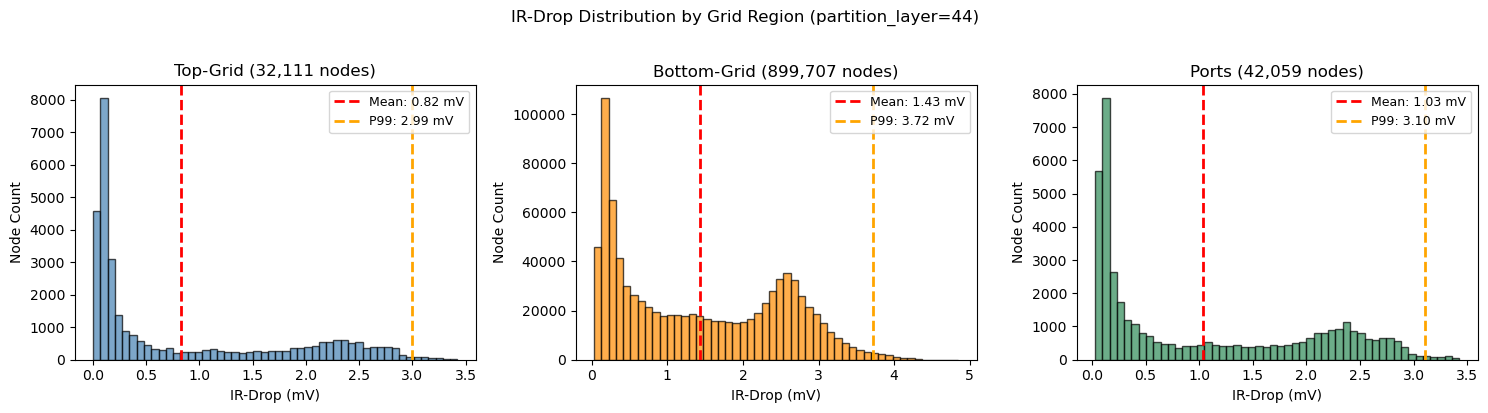

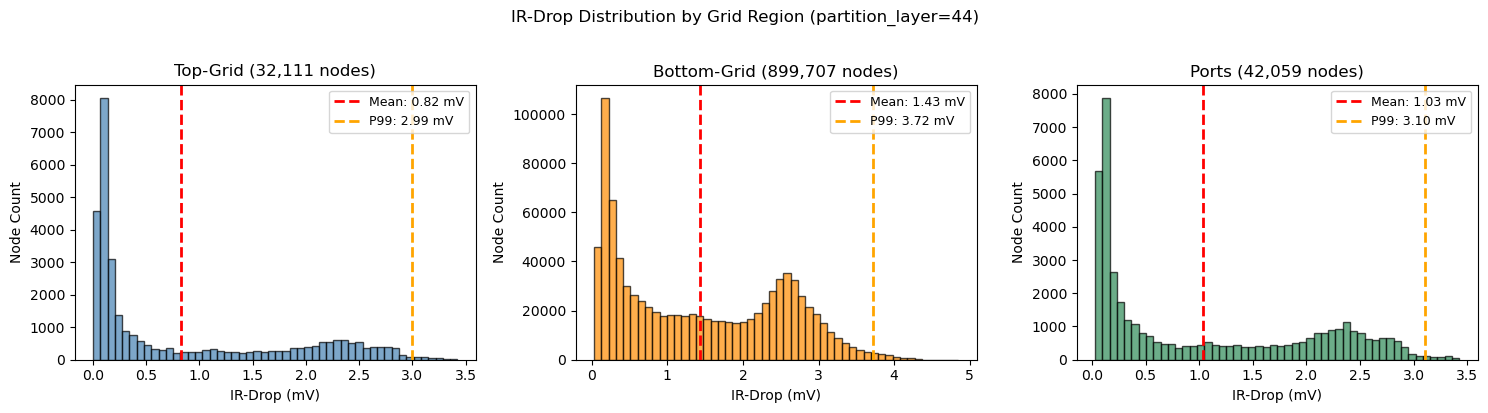

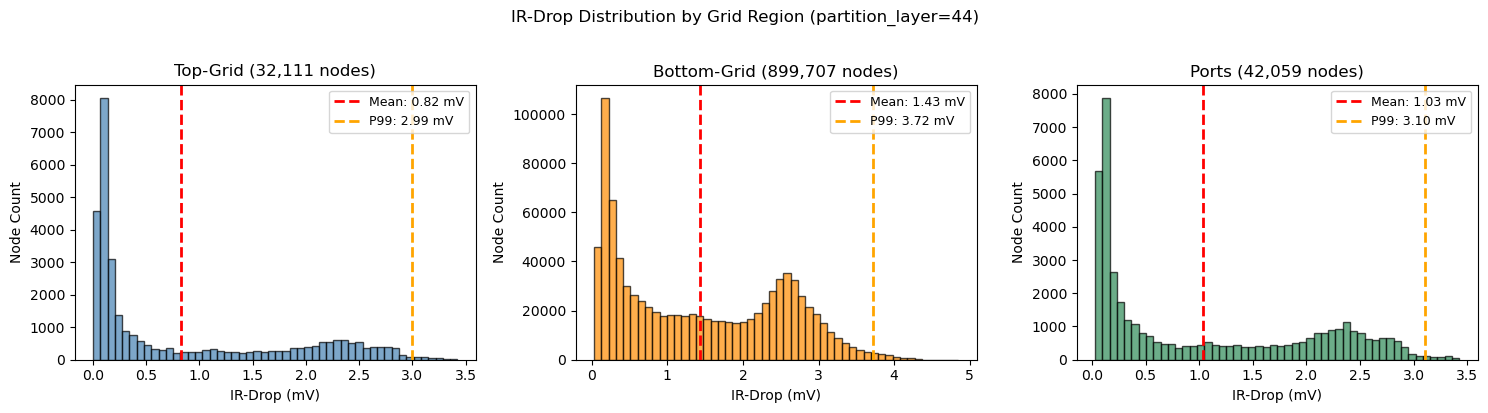

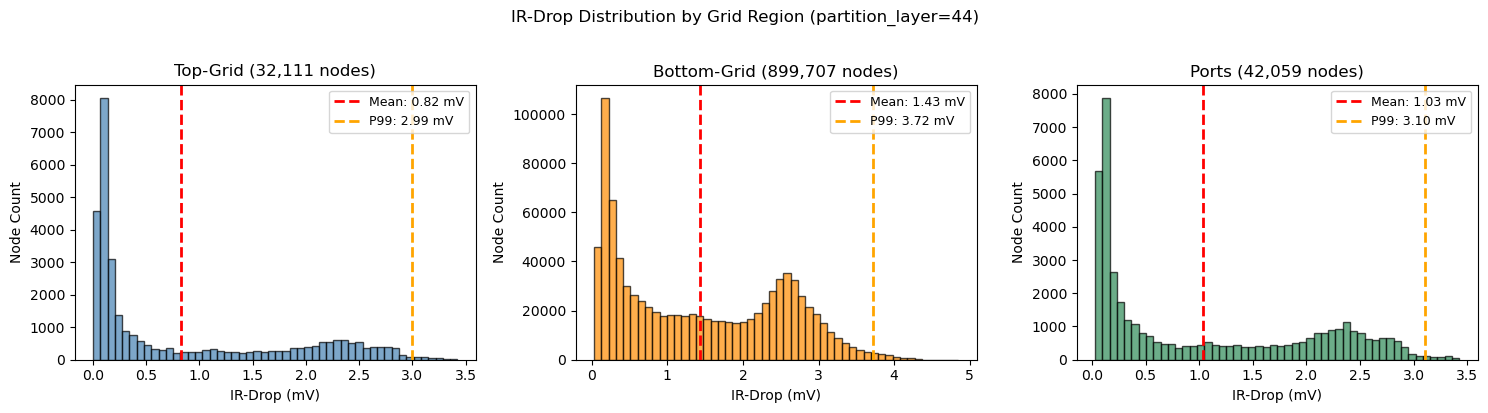

In [11]:
%matplotlib inline
# Plot IR-Drop Distribution Histograms: Top-Grid vs Bottom-Grid vs Ports
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

regions = [
    (top_ir_drop, "Top-Grid", 'steelblue'),
    (bottom_ir_drop, "Bottom-Grid", 'darkorange'),
    (port_ir_drop, "Ports", 'seagreen'),
]

for ax, (ir_drop_dict, label, color) in zip(axes, regions):
    if len(ir_drop_dict) == 0:
        ax.set_title(f"{label} (no nodes)")
        ax.set_xlabel("IR-Drop (mV)")
        ax.set_ylabel("Node Count")
        continue
    
    drops_mV = np.array(list(ir_drop_dict.values())) * 1000
    
    # Histogram
    ax.hist(drops_mV, bins=50, edgecolor='black', alpha=0.7, color=color)
    
    # Add mean and P99 lines
    mean_val = drops_mV.mean()
    p99_val = np.percentile(drops_mV, 99)
    
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f} mV')
    ax.axvline(p99_val, color='orange', linestyle='--', linewidth=2, label=f'P99: {p99_val:.2f} mV')
    
    ax.set_xlabel("IR-Drop (mV)")
    ax.set_ylabel("Node Count")
    ax.set_title(f"{label} ({len(drops_mV):,} nodes)")
    ax.legend(loc='upper right', fontsize=9)

plt.suptitle(f"IR-Drop Distribution by Grid Region (partition_layer={partition_layer})", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 5. Tiled Hierarchical Solve

For large PDN grids, we can exploit spatial locality by tiling the bottom-grid into independent subproblems. Each tile is solved in parallel with:
- **Core region**: Nodes whose voltages are merged into final result
- **Halo region**: Extra nodes to capture boundary effects
- **Port nodes**: Dirichlet BCs using top-grid port voltages

This enables parallel processing and can be extended to distributed computing.

In [9]:
# Reload modules to pick up any code changes
import importlib
import core.unified_solver
importlib.reload(core.unified_solver)

# Re-import the solver class
from core.unified_solver import UnifiedIRDropSolver
solver = UnifiedIRDropSolver(model)
print("Modules reloaded and solver recreated")

Modules reloaded and solver recreated


In [12]:
# Hierarchical solve using shortest_path (least-resistive path) weighting
# at partition layer 29 (or the adjusted layer from earlier)
#partition_layer = '32'
partition_layer = 'M3'

print(f"Hierarchical Solve using SHORTEST_PATH (least-resistive) weighting")
print(f"Partition layer: {partition_layer}")
print("="*60)

hier_result = solver.solve_hierarchical_tiled(
        load_currents,
        partition_layer=partition_layer,
        top_k=5,
        weighting="shortest_path",  # Use least-resistive path
        N_x=4,
        N_y=4,
        halo_percent=0.2,
        n_workers=1,
        parallel_backend='thread',
        validate_against_flat=True,
        verbose=True,
    )
# hier_result = solver.solve_hierarchical(
#     load_currents,
#     partition_layer=partition_layer,
#     top_k=5,
#     weighting="shortest_path",  # Use least-resistive path
#     verbose=True,
# )

# Get summary (excludes pad nodes from statistics)
hier_summary = solver.summarize(hier_result)

print(f"\nHierarchical Solver Results:")
print(f"  Ports: {len(hier_result.port_nodes)}")
print(f"  Nominal voltage: {hier_summary['nominal_voltage']:.6f} V")
print(f"  Min voltage: {hier_summary['min_voltage']:.6f} V")
print(f"  Max voltage: {hier_summary['max_voltage']:.6f} V")
print(f"  Max IR-drop: {hier_summary['max_drop']*1000:.4f} mV")
print(f"  Avg IR-drop: {hier_summary['avg_drop']*1000:.4f} mV")

# Compute errors
errors = []
for node in flat_result.voltages:
    if node in hier_result.voltages:
        error = abs(flat_result.voltages[node] - hier_result.voltages[node])
        errors.append(error)

if errors:
    errors = np.array(errors)
    print(f"\nVoltage Error Analysis:")
    print(f"  Max error:  {errors.max()*1000:.4f} mV ({errors.max()/model.vdd*100:.4f}% of Vdd)")
    print(f"  Mean error: {errors.mean()*1000:.4f} mV ({errors.mean()/model.vdd*100:.4f}% of Vdd)")
    print(f"  RMS error:  {np.sqrt((errors**2).mean())*1000:.4f} mV")
    print(f"  Nodes compared: {len(errors)}")


Hierarchical Solve using SHORTEST_PATH (least-resistive) weighting
Partition layer: M3

=== Tiled Hierarchical Solve Timing ===
  Top nodes: 1,539, Bottom nodes: 5,000
  Ports: 625, Tiles: 16
  Grid: 4x4, Halo: 20%
  Workers: 1, Backend: thread
  ---
  decompose                :    136.9 ms  (  6.7%)
  connectivity_check       :    167.7 ms  (  8.2%)
  aggregate_currents       :    820.7 ms  ( 40.3%)
  build_top_system         :     14.9 ms  (  0.7%)
  solve_top                :      2.2 ms  (  0.1%)
  extract_coords           :     35.7 ms  (  1.8%)
  generate_tiles           :     49.4 ms  (  2.4%)
  expand_halos             :     22.1 ms  (  1.1%)
  fix_connectivity         :    303.7 ms  ( 14.9%)
  build_args               :    112.1 ms  (  5.5%)
  solve_tiles              :    251.9 ms  ( 12.4%)
  merge_results            :      2.8 ms  (  0.1%)
  validate                 :    117.0 ms  (  5.7%)
  TOTAL                    :   2037.0 ms
  --- Validation ---
  Max diff: 1.4602 mV
  

In [13]:
# Tiled Hierarchical Solve
# Partition the bottom-grid into N_x × N_y tiles and solve each independently

print(f"Tiled Hierarchical Solve (partition_layer={partition_layer})")
print("="*70)

# Run tiled hierarchical solve with 2x2 grid
tiled_result = solver.solve_hierarchical_tiled(
    current_injections=load_currents,
    partition_layer=partition_layer,
    N_x=2,
    N_y=2,
    halo_percent=0.2,           # 20% halo overlap
    top_k=5,
    weighting='shortest_path',
    n_workers=4,                # Parallel workers
    parallel_backend='thread',  # Use 'process' for larger grids
    validate_against_flat=True, # Compare against non-tiled solve
    verbose=True,
)

# Get summary
tiled_summary = solver.summarize(tiled_result)

print(f"\nTiled Hierarchical Solver Results:")
print(f"  Tiles: {len(tiled_result.tiles)}")
print(f"  Ports: {len(tiled_result.port_nodes)}")
print(f"  Nominal voltage: {tiled_summary['nominal_voltage']:.6f} V")
print(f"  Min voltage: {tiled_summary['min_voltage']:.6f} V")
print(f"  Max voltage: {tiled_summary['max_voltage']:.6f} V")
print(f"  Max IR-drop: {tiled_summary['max_drop']*1000:.4f} mV")
print(f"  Avg IR-drop: {tiled_summary['avg_drop']*1000:.4f} mV")

# Show per-tile timing
print(f"\nPer-Tile Solve Times:")
for tile_id, time_ms in sorted(tiled_result.per_tile_solve_times.items()):
    print(f"  Tile {tile_id}: {time_ms:.1f} ms")

# Show validation against non-tiled bottom-grid solve
if tiled_result.validation_stats:
    print(f"\nValidation vs Non-Tiled Bottom-Grid Solve:")
    print(f"  Max diff:  {tiled_result.validation_stats['max_diff']*1000:.4f} mV")
    print(f"  Mean diff: {tiled_result.validation_stats['mean_diff']*1000:.4f} mV")
    print(f"  RMSE:      {tiled_result.validation_stats['rmse']*1000:.4f} mV")
    print(f"  Nodes compared: {tiled_result.validation_stats['num_compared']}")
    
    if tiled_result.validation_stats['max_diff'] < 0.001:
        print(f"\n✓ TILED SOLVE ACCURATE: Max error < 1 mV")
    else:
        print(f"\n⚠ TILED SOLVE WARNING: Max error >= 1 mV")

# Show halo clipping warnings
if tiled_result.halo_clip_warnings:
    print(f"\nHalo Clipping Warnings: Tiles {tiled_result.halo_clip_warnings}")

Tiled Hierarchical Solve (partition_layer=M3)

=== Tiled Hierarchical Solve Timing ===
  Top nodes: 1,539, Bottom nodes: 5,000
  Ports: 625, Tiles: 4
  Grid: 2x2, Halo: 20%
  Workers: 4, Backend: thread
  ---
  decompose                :    139.9 ms  (  6.0%)
  connectivity_check       :    153.0 ms  (  6.5%)
  aggregate_currents       :    907.7 ms  ( 38.7%)
  build_top_system         :     19.4 ms  (  0.8%)
  solve_top                :      2.7 ms  (  0.1%)
  extract_coords           :    322.5 ms  ( 13.7%)
  generate_tiles           :     22.5 ms  (  1.0%)
  expand_halos             :      5.3 ms  (  0.2%)
  fix_connectivity         :    246.4 ms  ( 10.5%)
  build_args               :     78.5 ms  (  3.3%)
  solve_tiles              :    297.5 ms  ( 12.7%)
  merge_results            :      5.3 ms  (  0.2%)
  validate                 :    147.5 ms  (  6.3%)
  TOTAL                    :   2348.3 ms
  --- Validation ---
  Max diff: 1.6151 mV
  Mean diff: 0.2624 mV
  RMSE: 0.3733 mV
  -

In [14]:
# Compare Tiled vs Flat Solver Results
print("Comparison: Tiled Hierarchical vs Flat Solver")
print("="*70)

# Compute errors against flat solver
tiled_errors = []
for node in flat_result.voltages:
    if node in tiled_result.voltages:
        error = abs(flat_result.voltages[node] - tiled_result.voltages[node])
        tiled_errors.append(error)

if tiled_errors:
    tiled_errors = np.array(tiled_errors)
    print(f"\nTiled vs Flat Solver Voltage Errors:")
    print(f"  Max error:  {tiled_errors.max()*1000:.4f} mV ({tiled_errors.max()/model.vdd*100:.4f}% of Vdd)")
    print(f"  Mean error: {tiled_errors.mean()*1000:.4f} mV ({tiled_errors.mean()/model.vdd*100:.4f}% of Vdd)")
    print(f"  RMS error:  {np.sqrt((tiled_errors**2).mean())*1000:.4f} mV")
    print(f"  Nodes compared: {len(tiled_errors)}")

# Compare with non-tiled hierarchical solver
print(f"\nComparison Summary:")
print(f"  {'Method':<30} {'Max IR-drop (mV)':<20} {'Max Error vs Flat (mV)'}")
print(f"  {'-'*70}")
print(f"  {'Flat Solver':<30} {summary['max_drop']*1000:.4f}")
print(f"  {'Hierarchical (non-tiled)':<30} {solver.summarize(hier_result)['max_drop']*1000:.4f} {errors.max()*1000:.4f}")
print(f"  {'Hierarchical (tiled 2x2)':<30} {tiled_summary['max_drop']*1000:.4f} {tiled_errors.max()*1000:.4f}")

Comparison: Tiled Hierarchical vs Flat Solver

Tiled vs Flat Solver Voltage Errors:
  Max error:  3.6817 mV (0.4909% of Vdd)
  Mean error: 2.4603 mV (0.3280% of Vdd)
  RMS error:  2.4869 mV
  Nodes compared: 6539

Comparison Summary:
  Method                         Max IR-drop (mV)     Max Error vs Flat (mV)
  ----------------------------------------------------------------------
  Flat Solver                    10.0169
  Hierarchical (non-tiled)       13.3463 3.6817
  Hierarchical (tiled 2x2)       13.3479 3.6817


In [15]:
# Inspect Tile Structure
print("Tile Structure Details")
print("="*70)

for tile in tiled_result.tiles:
    bounds = tile.bounds
    print(f"\nTile {tile.tile_id}:")
    print(f"  Bounds: x=[{bounds.x_min:.0f}, {bounds.x_max:.0f}], y=[{bounds.y_min:.0f}, {bounds.y_max:.0f}]")
    print(f"  Core nodes: {len(tile.core_nodes)}")
    print(f"  Halo nodes: {len(tile.halo_nodes)}")
    print(f"  Port nodes: {len(tile.port_nodes)}")
    print(f"  Load nodes: {len(tile.load_nodes)}")
    print(f"  Total nodes (core+halo+ports): {len(tile.all_nodes)}")
    print(f"  Halo clipped: {tile.halo_clipped}")

# Verify disjoint cores
all_cores = set()
for tile in tiled_result.tiles:
    overlap = all_cores & tile.core_nodes
    if overlap:
        print(f"\n⚠ WARNING: Core overlap detected! {len(overlap)} nodes")
    all_cores.update(tile.core_nodes)

print(f"\n✓ Total unique core nodes: {len(all_cores)}")
print(f"✓ All tile cores are disjoint: {len(all_cores) == sum(len(t.core_nodes) for t in tiled_result.tiles)}")

Tile Structure Details

Tile 0:
  Bounds: x=[2000, 60800], y=[2000, 51000]
  Core nodes: 1500
  Halo nodes: 660
  Port nodes: 270
  Load nodes: 310
  Total nodes (core+halo+ports): 2430
  Halo clipped: True

Tile 1:
  Bounds: x=[51000, 100000], y=[2000, 55900]
  Core nodes: 1100
  Halo nodes: 880
  Port nodes: 240
  Load nodes: 206
  Total nodes (core+halo+ports): 2220
  Halo clipped: True

Tile 2:
  Bounds: x=[2000, 55900], y=[51000, 100000]
  Core nodes: 1342
  Halo nodes: 638
  Port nodes: 240
  Load nodes: 275
  Total nodes (core+halo+ports): 2220
  Halo clipped: True

Tile 3:
  Bounds: x=[51000, 100000], y=[51000, 100000]
  Core nodes: 1058
  Halo nodes: 742
  Port nodes: 225
  Load nodes: 209
  Total nodes (core+halo+ports): 2025
  Halo clipped: True

✓ Total unique core nodes: 5000
✓ All tile cores are disjoint: True
